In [1]:
import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs

import time
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import insituFuncs as iF

plt.style.use('default')
plt.rcParams["figure.figsize"][0] = 16
plt.rcParams["figure.figsize"][1] = 9
plt.rcParams['errorbar.capsize']=2

In [2]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-2/output'
h_const=il.groupcat.loadHeader(basePath,99)['HubbleParam']
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']

In [3]:
f = h5py.File(basePath[:-6]+'postprocessing/StellarAssembly/galaxies_099.hdf5','r')
stellar_mass = f['StellarMassTotal'][:]
exsitu_stellar_mass = f['StellarMassExSitu'][:]
frac = exsitu_stellar_mass[np.where(stellar_mass>0)[0]] / stellar_mass[np.where(stellar_mass>0)[0]]
stellar_mass = np.log10(stellar_mass[np.where(stellar_mass>0)[0]] * 1e10/h_const)
f.close()

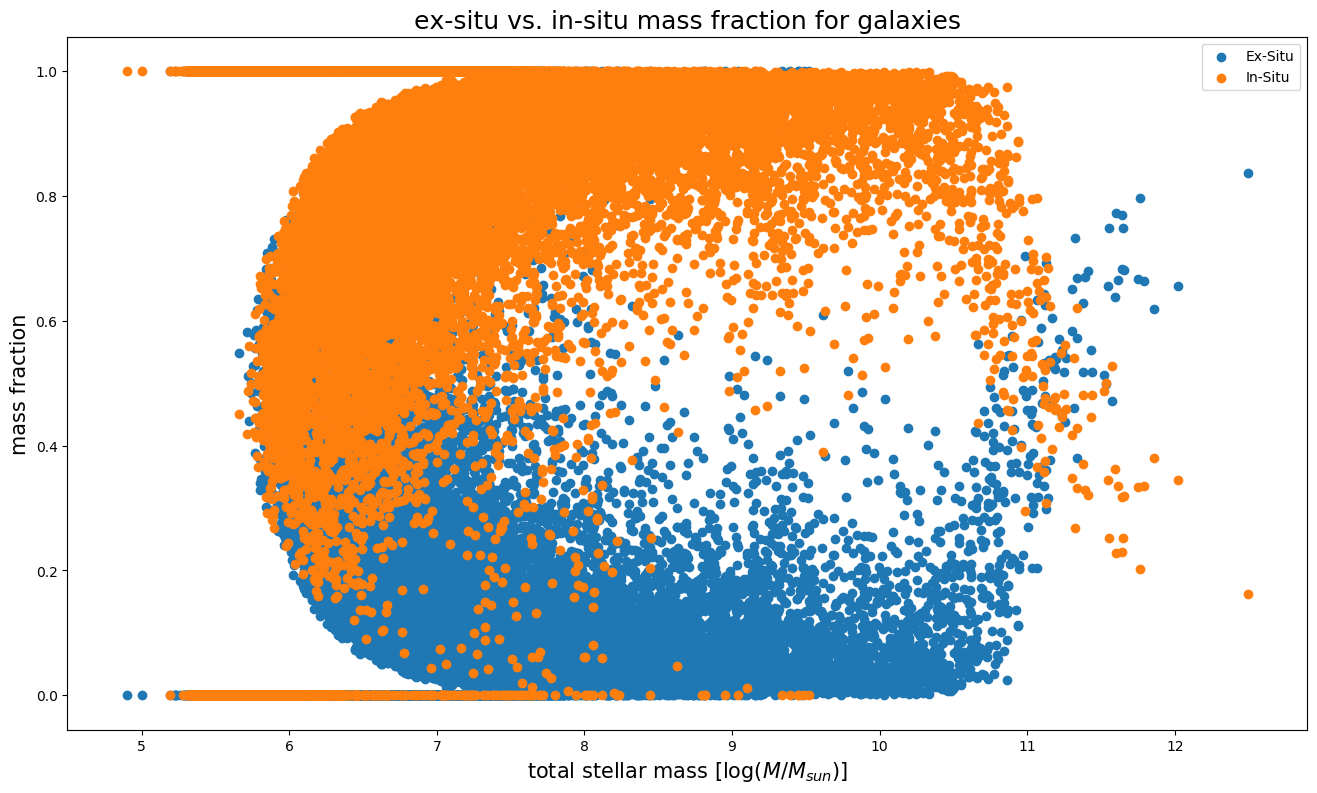

In [7]:
plt.scatter(stellar_mass,frac,label='Ex-Situ')
plt.scatter(stellar_mass,1-frac,label='In-Situ')
plt.ylabel('mass fraction',size=15)
plt.xlabel('total stellar mass [$\log(M/M_{sun})$]',size=15)
plt.title('ex-situ vs. in-situ mass fraction for galaxies',size=18)
plt.legend()

In [3]:
def AllTracerProfile_wMassBins(basePath,start_snap,target_snap):
    header = il.groupcat.loadHeader(basePath,target_snap)
    redshift = header['Redshift']
    h_const = header['HubbleParam']
    boxSize = header['BoxSize']
    
    parent_indices = h5py.File('files/'+basePath[32:39]+'/parent_indices_redshift_{:.1f}.hdf5'.format(redshift),'r')
    sub_positions = h5py.File('files/'+basePath[32:39]+'/SubhaloPosAtAllSnaps_extrapolated.hdf5','r') 
    is_extrapolated = sub_positions['is_extrapolated'][:]
    
    sub_means = np.zeros(np.where(is_extrapolated)[0].shape)
    
    #print(np.where(is_extrapolated==False)[0])
    #possibly, the position at that snapshot had to be extrapolated
    
    sub_pos_at_target_snap = sub_positions['SubhaloPos'][:,:,:]
    num_subs = sub_pos_at_target_snap.shape[0]

    parent_indices_data = parent_indices['parent_indices'][:,:]
    tracers_in_parent_offset = parent_indices['tracers_in_parents_offset'][:]
    
    all_gas_pos = il.snapshot.loadSubset(basePath,target_snap,'gas',fields=['Coordinates'])
    sub_masses = il.groupcat.loadSubhalos(basePath,start_snap,fields=['SubhaloMass']) * 1e10/h_const
    
    mass_bin1 = np.where(sub_masses<1e9)[0]
    mass_bin2 = np.where(np.logical_and(sub_masses>=1e9,sub_masses<1e10))[0]
    mass_bin3 = np.where(np.logical_and(sub_masses>=1e10,sub_masses<1e11))[0]
    mass_bin4 = np.where(np.logical_and(sub_masses>=1e11,sub_masses<1e12))[0]
    mass_bin5 = np.where(sub_masses>=1e12)[0]
    num_mass_bins = 5

    f = h5py.File(basePath[:-6] + 'postprocessing/offsets/offsets_0' + str(start_snap) + '.hdf5','r')
    starsInSubOffset = f['Subhalo/SnapByType'][:,4]
    f.close()
    
    insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath,target_snap)
    
    #there might be more tracers -> parents in one galaxy at higher redshifts than insitu stars at redshift 0
    final_offsets = tF.tracersInSubhalo(insituStarsInSubOffset,tracers_in_parent_offset)
    
    counter = 0
    num_bins = 100
    bins = np.zeros((num_mass_bins,num_bins))
    num = np.zeros((num_mass_bins,num_bins))
    mass_means = np.zeros(5)
    numPerBin = np.zeros(5)
    
    for i in range(num_mass_bins):
        mass_rad_profile = np.zeros(1)
        bin_counter = 0
        for index in locals()["mass_bin"+str(i+1)]:
            if is_extrapolated[index]:
                parent_indices_of_sub = parent_indices_data[int(final_offsets[index-1]):int(final_offsets[index]),:]
                gas_parent_indices = parent_indices_of_sub[np.where(parent_indices_of_sub[:,1]==0)[0],0]
                gas_pos = all_gas_pos[gas_parent_indices.astype('int')]
    
                subhalo_position = sub_pos_at_target_snap[index-1,start_snap-target_snap,:]
    
                rad_dist = np.ones(gas_pos.shape[0])
                for j in range(gas_pos.shape[0]):
                    rad_dist[j] = iF.dist(subhalo_position,gas_pos[j],boxSize)
                    
                mass_rad_profile = np.concatenate((mass_rad_profile,rad_dist))
                mass_rad_profile = mass_rad_profile[np.where(mass_rad_profile<boxSize)[0]]
                
                if rad_dist.shape[0]>0:
                    sub_means[counter] = np.mean(rad_dist)
                else:
                    sub_means[counter] = 0
                counter+=1
                bin_counter+=1
        #compute mean distance for each mass bin
        mean = np.mean(mass_rad_profile)
        mass_means[i] = mean
        bins[i,:], num[i,:] = iF.binData(mass_rad_profile,num_bins)
        numPerBin[i] = bin_counter
        
    for k in range(5):
        num[k,:]=num[k,:]/sum(num[k,:])
    parent_indices.close()
    sub_positions.close()
    return bins, num, mass_means, sub_means, numPerBin

In [22]:
basePath='/virgotng/universe/IllustrisTNG/TNG50-3/output'
bins, num, mass_means, sub_means, numPerBin = AllTracerProfile_wMassBins(basePath,99,25)

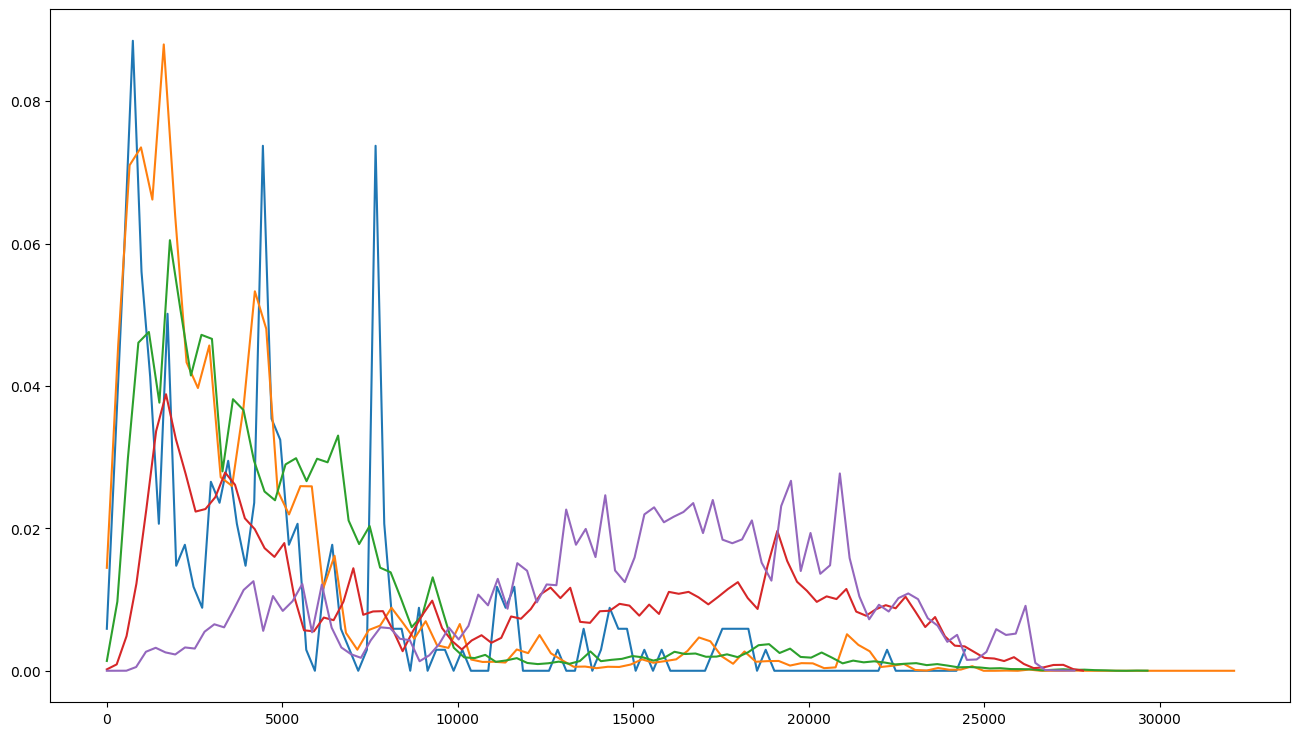

In [23]:
for i in range(5):
    plt.plot(bins[i],num[i])

In [44]:
@njit
def running_median(y,size):
    if size>y.shape[0]:
        return None
    med = np.zeros(y.shape[0])
    for i in range(int(size/2) , y.shape[0]-int(size/2)):
        #if i > int(size/2) and i < y.shape[0] - int(size/2):
        med[i] = np.median(y[i-int(size/2):i+int(size/2)])
        #elif i > y.shape[0] - int(size/2):
            #med[i] = np.median(y[i-int(size/2):])
        #else:
            #med[i] = np.median(y[:i+int(size/2)])
    return med

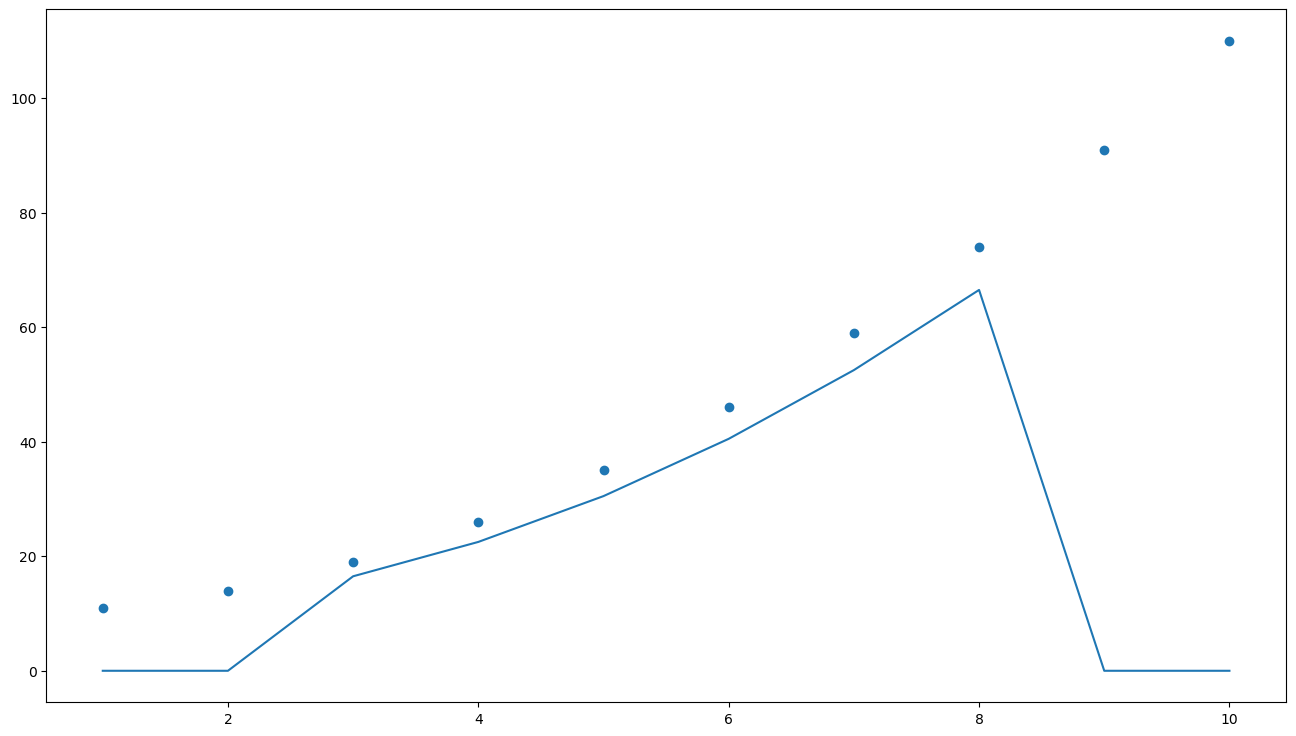

In [45]:
x = np.arange(1,11)
y = x**2 + 10
plt.scatter(x,y)
plt.plot(x,running_median(y,size = 4))

In [24]:
header = il.groupcat.loadHeader(basePath,25)
redshift = header['Redshift']
h_const = header['HubbleParam']

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


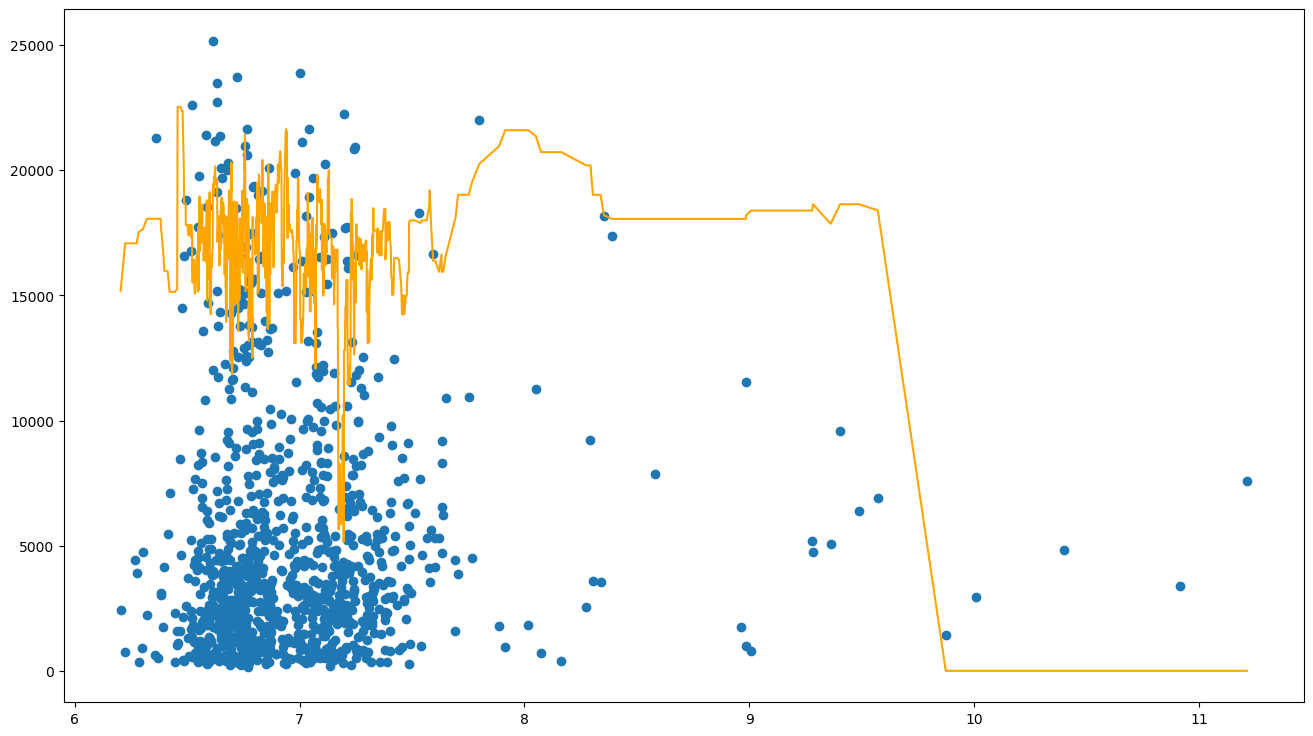

In [46]:
sub_positions = h5py.File('files/'+basePath[32:39]+'/SubhaloPosAtAllSnaps_extrapolated.hdf5','r') 
is_extrapolated = sub_positions['is_extrapolated'][:]
sub_positions.close()

stellar_masses = il.groupcat.loadSubhalos(basePath, 25, fields = ['SubhaloMassType'])[:,4] * 1e10/h_const
stellar_masses = stellar_masses[np.where(is_extrapolated)[0]]
mask = np.where(sub_means!=0)[0]
stellar_masses = np.log10(stellar_masses[mask])
sub_means_masked = sub_means[mask]

plt.scatter(stellar_masses,sub_means_masked)
med = running_median(y=sub_means_masked,size=10)
x = stellar_masses[np.argsort(stellar_masses)]
plt.plot(x,med,color = 'orange')
#plt.scatter(np.log10(stellar_masses[int(numPerBin[0]):int(numPerBin[1])]),sub_means[int(numPerBin[0]):int(numPerBin[1])])

In [129]:
def one_gal_profile_vs_redshift(basePath, subID = 0, max_dist = 15000, onlyGas = False):
    header = il.groupcat.loadHeader(basePath,99)
    boxSize = header['BoxSize']
    
    f = h5py.File('files/'+basePath[32:39]+'/all_parent_indices.hdf5','r')
    tracers_in_parent_offset = f['snap_099/tracers_in_parents_offset'][:]
    snaps = np.arange(99,1,-1)
    problem = []
    for i in range(99,1,-1):
        if f'snap_0{i}' not in f:
            problem.append(99 - i)
    f.close()
    snaps = np.delete(snaps,problem)
    
    sub_positions = h5py.File('files/' + basePath[32:39] + '/SubhaloPosAtAllSnaps_extrapolated.hdf5','r') 
    sub_pos = sub_positions['SubhaloPos'][subID,:,:]
    sub_positions.close()
    
    insituStarsInSubOffset = tF.insituStarsInSubOffset(basePath,99)
    #there might be more tracers -> parents in one galaxy at higher redshifts than insitu stars at redshift 0
    parentsInSubOffset = tF.tracersInSubhalo(insituStarsInSubOffset,tracers_in_parent_offset).astype(int)
    parentsInSubOffset = np.insert(parentsInSubOffset,0,0)
    
    num_bins = snaps.size
    bins = np.linspace(0,max_dist,num_bins)
    num = np.zeros((snaps.size,num_bins))
    z = np.zeros(snaps.size)
    snap_count = 0
    tree = il.sublink.loadTree(basePath,99,subID,fields=['SubfindID'],onlyMPB = True)
    
    for i in range(snaps.size):
    #for i in range(1):        
        all_parent_indices = h5py.File('files/' + basePath[32:39] + '/all_parent_indices.hdf5','r')
        parent_indices = all_parent_indices[f'snap_0{snaps[i]}/parent_indices']\
        [parentsInSubOffset[subID]:parentsInSubOffset[subID+1],:]
        
        all_gas_pos = il.snapshot.loadSubset(basePath, snaps[i], 'gas', fields = ['Coordinates'])
        gas_parent_indices = parent_indices[np.where(parent_indices[:,1] == 0)[0],0]
        gas_pos = all_gas_pos[gas_parent_indices.astype(int)]
        if not onlyGas:
            all_star_pos = il.snapshot.loadSubset(basePath, snaps[i], 'stars', fields = ['Coordinates'])
            star_parent_indices = parent_indices[np.where(parent_indices[:,1] == 1)[0],0]
            star_pos = all_star_pos[star_parent_indices.astype(int)]
        
        

        #subhalo_position = il.groupcat.loadSubhalos(basePath,snaps[i],fields=['SubhaloPos'])[tree[99-snaps[i]]]#sub_pos[snap_count,:]
        subhalo_position = sub_pos[99-snaps[i]]
        
        rad_dist = np.zeros(gas_pos.shape[0])
        if not onlyGas:
            rad_dist = np.zeros(gas_pos.shape[0] + star_pos.shape[0])
        for j in range(gas_pos.shape[0]):
            rad_dist[j] = iF.dist(subhalo_position,gas_pos[j],boxSize)
        if not onlyGas:
            for j in range(star_pos.shape[0]):
                rad_dist[gas_pos.shape[0] + j] = iF.dist(subhalo_position,star_pos[j],boxSize)
        
        num[i,:] = iF.binData_w_bins(rad_dist,bins = bins)
        num[i,:] = num[i,:]/sum(num[i,:]) #we're only interested in the fraction of tracers in that bin
        z[i] = il.groupcat.loadHeader(basePath, snaps[i])['Redshift']
        print(snaps[i],' done;',end=' ',flush=True)
    all_parent_indices.close()
    return bins, num, z

In [130]:
%%time
basePath = '/virgotng/universe/IllustrisTNG/TNG50-4/output'
bins, num, z = one_gal_profile_vs_redshift(basePath, subID = 0, max_dist = 400, onlyGas = False)

(0,)
99  done; 

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


(5,)
98  done; (5,)
97  done; (5,)
96  done; (9,)
95  done; (8,)
94  done; (17,)
93  done; (22,)
92  done; (28,)
91  done; (31,)
90  done; (31,)
89  done; (30,)
88  done; (30,)
87  done; (30,)
86  done; (30,)
85  done; (29,)
84  done; (30,)
83  done; (30,)
82  done; (30,)
81  done; (31,)
80  done; (31,)
79  done; (48,)
78  done; (48,)
77  done; (48,)
76  done; (48,)
75  done; (49,)
74  done; (49,)
73  done; (49,)
72  done; (49,)
71  done; (49,)
70  done; (49,)
69  done; (49,)
68  done; (49,)
67  done; (49,)
66  done; (49,)
65  done; (49,)
64  done; (49,)
63  done; (50,)
62  done; (52,)
61  done; (59,)
60  done; (79,)
59  done; (96,)
58  done; (120,)
57  done; (143,)
56  done; (180,)
55  done; (206,)
54  done; (226,)
53  done; (228,)
52  done; (231,)
51  done; (240,)
50  done; (265,)
49  done; (280,)
48  done; (310,)
47  done; (314,)
46  done; (332,)
45  done; (338,)
44  done; (348,)
43  done; (354,)
42  done; (361,)
41  done; (390,)
40  done; (399,)
39  done; (422,)
38  done; (449,)
37

Text(0.5, 1.0, 'evolution of radial profile of tracer fraction')

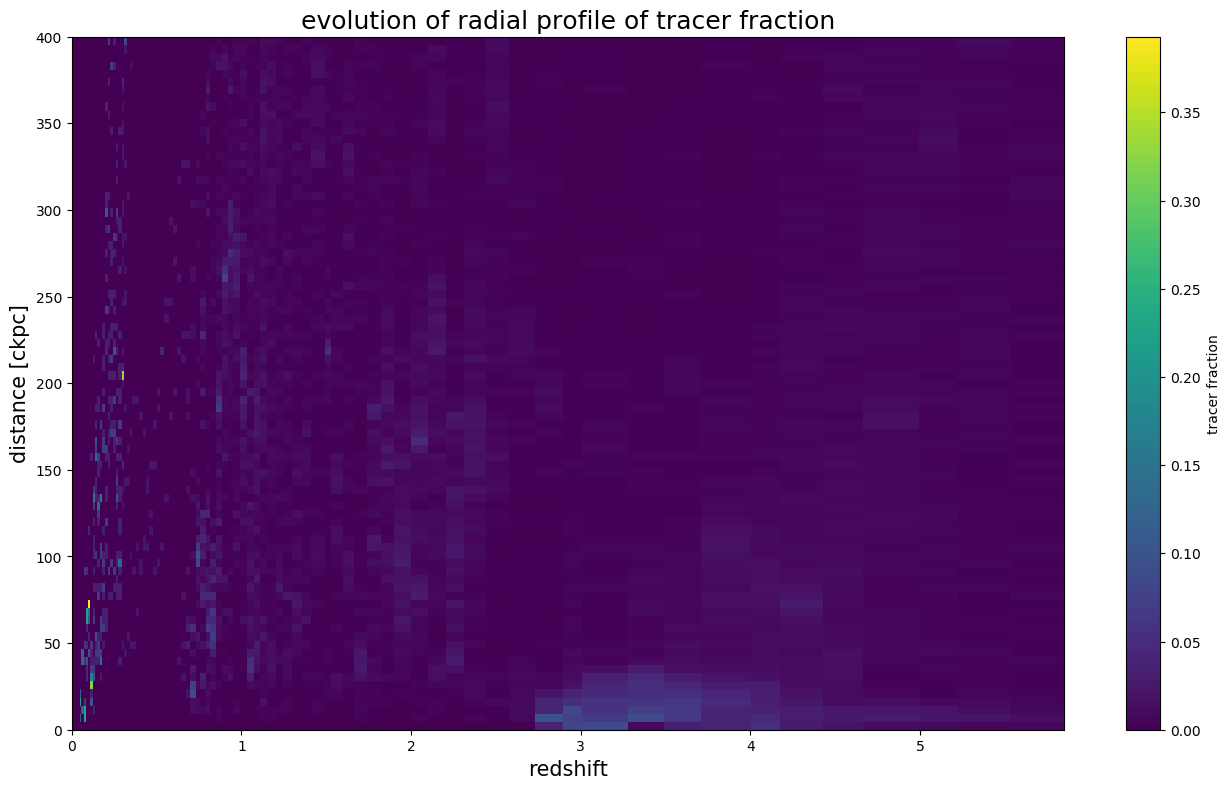

In [131]:
plt.pcolormesh(z,bins,num.T)
plt.colorbar(label='tracer fraction')
plt.ylabel('distance [ckpc]',size=15)
plt.xlabel('redshift',size=15)
plt.title('evolution of radial profile of tracer fraction',size=18)
#plt.savefig('pics/rad_prof_z_tracer_frac_sub0.jpg',format='jpg')

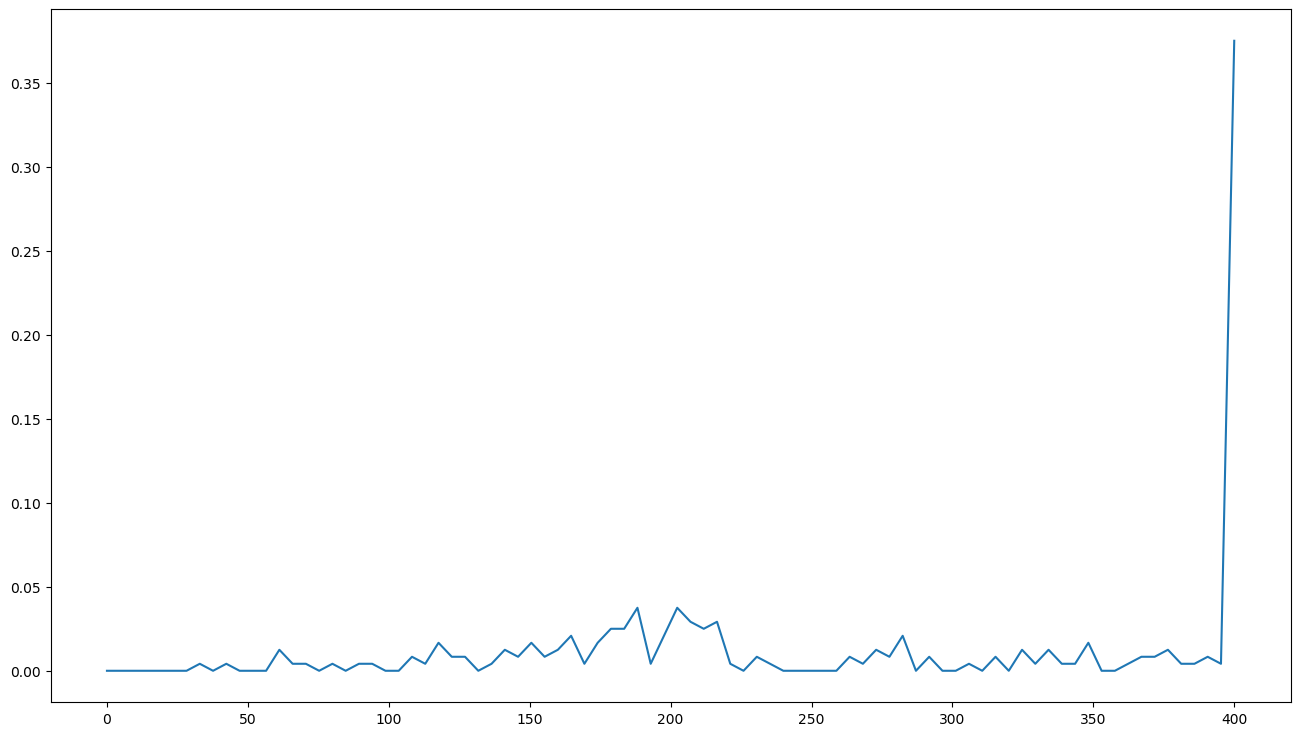

In [132]:
plt.plot(bins,num[99-50,:])

In [77]:
print(il.groupcat.loadSubhalos(basePath,25,fields=['SubhaloPos'])[0])

[22707.023  15311.82    3463.8704]


In [78]:
pos = il.snapshot.loadSubhalo(basePath,25,0, 'stars',fields=['Coordinates'])
print(pos[0,:])

[22706.45342474 15312.24570902  3464.07007179]


In [80]:
print(num[99-30,:10])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [94]:
tree = il.sublink.loadTree(basePath,99,0,fields=['SubfindID'],onlyMPB = True)
print(tree)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1   1
   1   1   0   0   0   1   1   1   1   1   1   1   1   1   1   1   1 165
 162 149 148 140 138 143 144 144 142 136 141 132 130 142 118 125 125   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  49  48  21   0   0   0   0   0   0   0   0   6  11  11  18  30  21
  28  99  75 175 162 128  57]
